In [46]:
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from scipy.io import readsav
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image spectral scan

In [47]:
import glob
import matplotlib.pyplot as plt
from astropy.io import fits

fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")

if not fits_files:
    print("No FITS files found in the directory.")
else:
    rel_wave_values = []  # we crete a list of wavelength values associated with each image spectral scal


    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            print(f"Processing file: {fits_file}")
            # hdul.info()  # just to show the HDU structure


            for i, hdu in enumerate(hdul):
                header = hdu.header

                # We extract the wavelength values
                try:
                    rel_wave = header['REL_WAVE']
                    rel_wave_values.append(rel_wave)
                    # print(f"  HDU {i} ({hdu.name}): REL_WAVE = {rel_wave}")
                except KeyError:
                     print(f"  HDU {i} ({hdu.name}): REL_WAVE keyword not found.")


                # if hdu.data is not None and hdu.data.ndim in [2, 3]:
                #     plt.figure(figsize=(8, 8))
                #     plt.imshow(hdu.data, cmap='gray', origin='lower')
                #     plt.colorbar(label='Intensity')
                #     plt.title(f'FITS Image - HDU {i}')
                #     plt.xlabel('X Pixel')
                #     plt.ylabel('Y Pixel')
                #     plt.show()

# # We check the wavelengths values
# if rel_wave_values:
#     print("\nAll REL_WAVE values:")
#     for value in rel_wave_values:
#         print(value)
# else:
#     print("\nNo REL_WAVE values found.")


Processing file: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/s000.ImagingSpectralScan_8542.fits
  HDU 0 (PRIMARY): REL_WAVE keyword not found.


Selected image from: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/s000.ImagingSpectralScan_8542.fits


<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | ColorizingArtist | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

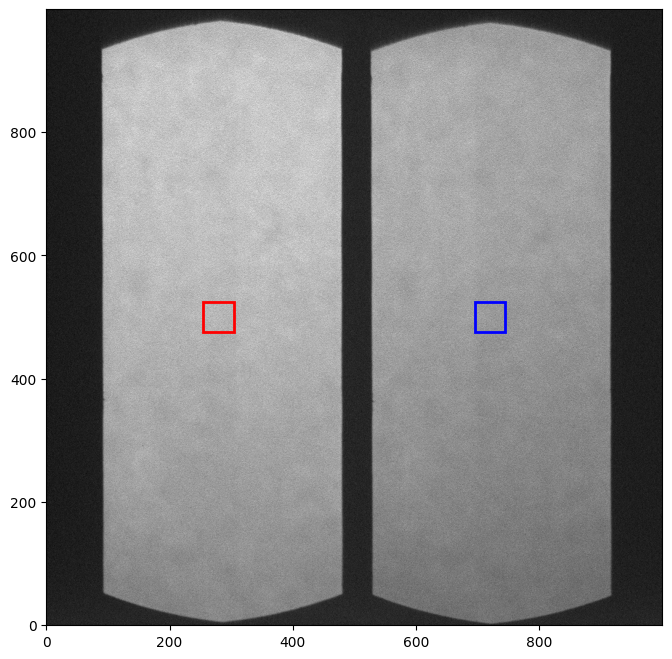

In [48]:
from matplotlib.patches import Rectangle

image_data = None  # inizializzazione

# Cerchiamo il primo file con dati validi da usare per image_data
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            if hdu.data is not None and hdu.data.ndim == 2:
                image_data = hdu.data
                print(f"Selected image from: {fits_file}")
                break
    if image_data is not None:
        break

if image_data is None:
    raise ValueError("No valid image data found in the FITS files.")

# We select the parameters to evaluate the average of the center
half_size = 25  # half of the dimensions of the region we want (50x50)

image_height, image_width = image_data.shape

# center in y (half of the image height)
y_center = image_height // 2

# Region 1 (x centered at half of the width - 220)
x_center_1 = image_width // 2 - 220
x_start_1 = x_center_1 - half_size
x_end_1 = x_center_1 + half_size

# Regione 2 (x centered at half of the width + 220)
x_center_2 = image_width // 2 + 220
x_start_2 = x_center_2 - half_size
x_end_2 = x_center_2 + half_size

# Evaluate the indexes of starting and ending of the regions
y_start = y_center - half_size
y_end = y_center + half_size


# Plot with box the two regions
plt.figure(figsize=(10, 8))
plt.imshow(image_data, cmap='gray', origin='lower')


rect1 = Rectangle((x_start_1, y_start),
                    width=2*half_size,
                    height=2*half_size,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none')
plt.gca().add_patch(rect1)


rect2 = Rectangle((x_start_2, y_start),
                    width=2*half_size,
                    height=2*half_size,
                    linewidth=2,
                    edgecolor='b',
                    facecolor='none')
plt.gca().add_patch(rect2)

plt.colorbar

In [49]:
if fits_files:
    with fits.open(fits_files[0]) as hdul:

        central_regions = []

        # We iterate all the HDUs (excluding the PRIMARY HDU)
        for hdu in hdul[1:]:
            data = hdu.data
            if data is not None:
                # We extract the two regions
                region_1 = data[y_start:y_end, x_start_1:x_end_1]
                region_2 = data[y_start:y_end, x_start_2:x_end_2]

                # We evaluate the mean
                central_region = np.mean([region_1, region_2])

                central_regions.append(central_region)

central_regions = (central_regions-np.min(central_regions)) / (np.max(central_regions)-np.min(central_regions))

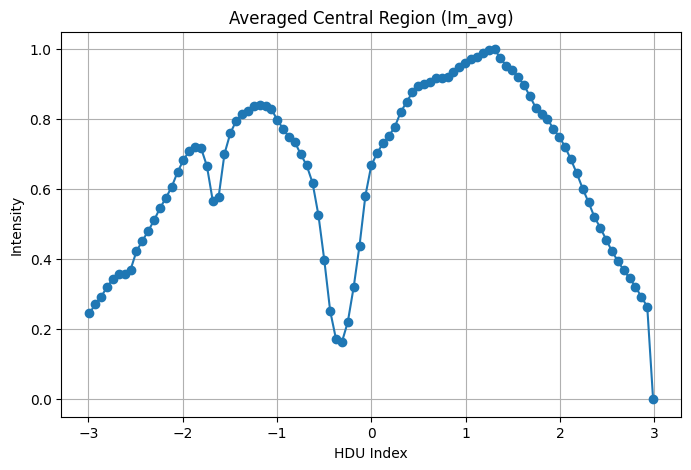

In [50]:

plt.figure(figsize=(8, 5))
plt.plot(rel_wave_values, central_regions, marker='o', linestyle='-')
plt.title('Averaged Central Region (Im_avg)')
plt.xlabel('HDU Index')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()


# PREFILTER

In [51]:



file_pattern = "/content/drive/MyDrive/IBIS_SWG/input/prefilter/*8542*.sav"
file_list = glob.glob(file_pattern)

if not file_list:
    print("No files found matching the pattern.")
else:
    for file_path in file_list:
        try:
            prefilter = readsav(file_path)
            print(f"Successfully read: {file_path}")
            # `data` is a dictionary-like object containing variables
        except Exception as e:
            print(f"Error reading {file_path}: {e}")




Successfully read: /content/drive/MyDrive/IBIS_SWG/input/prefilter/prefilter.8542.reference.profile.Apr2015.sav


In [52]:
prefilter.keys()

dict_keys(['prefilt8542_ref_wvscl', 'prefilt8542_ref_main', 'prefilt8542_fringe', 'prefilt8542_ref_interval', 'prefilt8542_ref_source'])

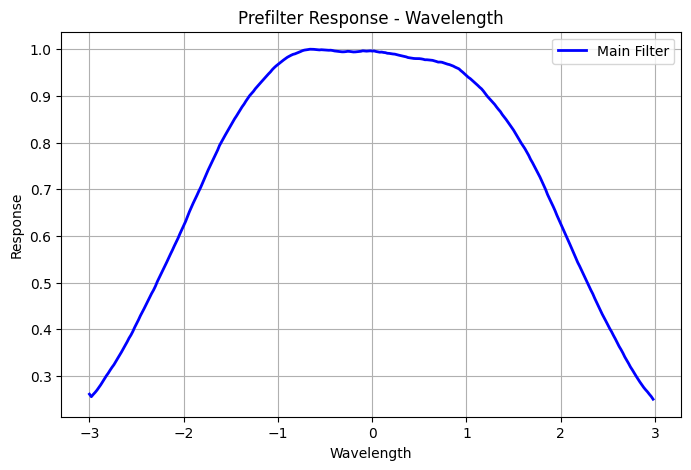

In [53]:

# Extract data
wavelengths = prefilter['prefilt8542_ref_wvscl']  # X-axis (wavelength scale)
main_filter = prefilter['prefilt8542_ref_main']   # Y-axis (main filter response)
fringe_filter = prefilter['prefilt8542_fringe']  # Y-axis (fringe response)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, main_filter, label="Main Filter", color='b', linewidth=2)


# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Response")
plt.title("Prefilter Response - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [54]:

wavelengths.shape
spacing = np.diff(wavelengths)   #The spacing is almost 0.02


In [55]:
# # Creiamo una nuova griglia con 97 punti (come central_regions)
# new_x = np.linspace(0, 1, 97)  # Griglia ridotta
# old_x = np.linspace(0, 1, 300)  # Griglia originale

# # Interpoliamo i valori di main_filter sulla nuova griglia
# main_filter_resampled = np.interp(new_x, old_x, main_filter)

# # Ora i due array sono compatibili
# Im_p = central_regions * main_filter_resampled

# print(f"Dimensione di Im_p: {Im_p.shape}")  # Deve restituire (97,)

# # Plot
# plt.figure(figsize=(8, 5))
# plt.plot(Im_p, label="Main Filter", color='b', linewidth=2)


# # Labels and title
# plt.xlabel("Wavelength")
# plt.ylabel("Response")
# plt.title("Prefilter Response - Wavelength")
# plt.legend()
# plt.grid()

# # Show plot
# plt.show()

Dimensione di Im_p: (300,)


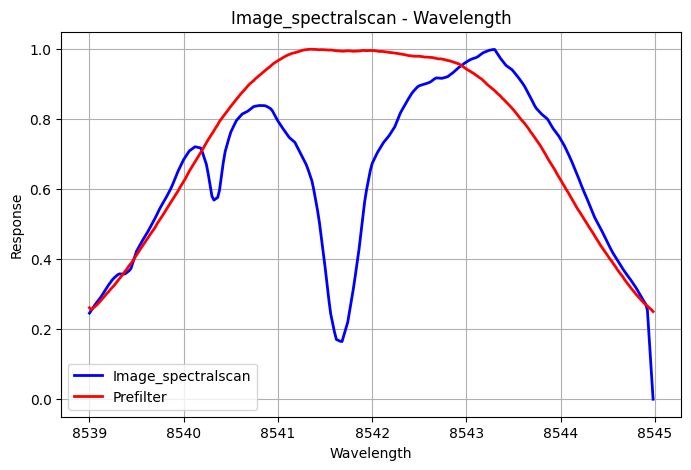

In [56]:
# Now we interpolate the Image  spectral scan profile on the Prefilter grid, to compare them, (??)

old_x = np.linspace(0, 1, 97)  # Griglia originale
new_x = np.linspace(0, 1, 300)  # Griglia

central_regions_resampled = np.interp(new_x, old_x, central_regions)

# Ora i due array sono compatibili
Im_p = central_regions_resampled

print(f"Dimensione di Im_p: {Im_p.shape}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths+8542, Im_p, label="Image_spectralscan", color='b', linewidth=2)
plt.plot(wavelengths+8542, main_filter, label="Prefilter", color='r', linewidth=2)

# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Response")
plt.title("Image_spectralscan - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()



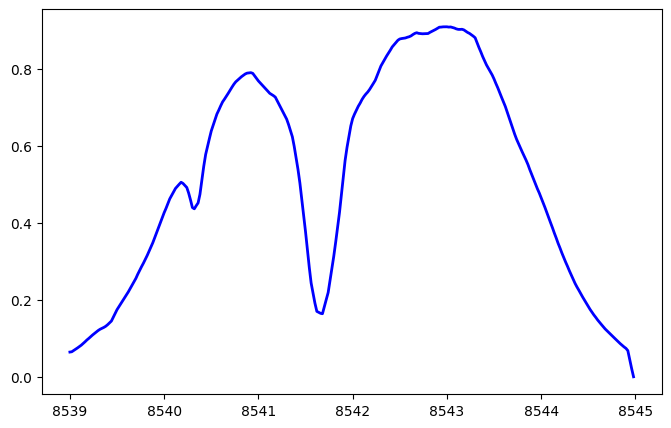

In [57]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths+8542, Im_p*main_filter, label="Image_spectralscan * main_filter", color='b', linewidth=2)


# Convolution

In [58]:
central_regions_conv= np.convolve(Im_p, main_filter, mode='same')

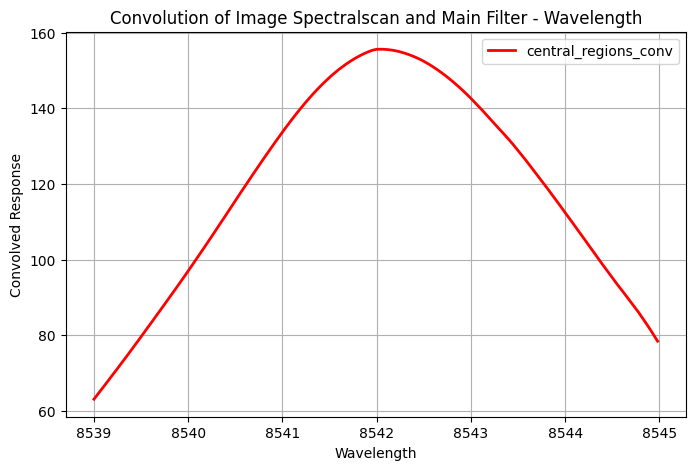

In [59]:


# Plot central_regions_conv as a function of wavelengths
plt.figure(figsize=(8, 5))
plt.plot(wavelengths + 8542, central_regions_conv, label="central_regions_conv", color='r', linewidth=2)

# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Convolved Response")
plt.title("Convolution of Image Spectralscan and Main Filter - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()


# ATLAS


In [60]:


# Find the index of the minimum value.
min_index = np.argmin(Im_p[20:-20])

# Print the index of the minimum value.
print(min_index)

min_wave_obs= wavelengths[20+min_index]
# print(min_wave_obs)
# wave_new= wavelengths+8542.116+0.32


114


In [61]:


def read_jung_fits(file, w1, w2, subsample=1):
    """
    Reads the Jungfraujoch solar spectrum from a FITS file.

    Parameters:
    - file: str, path to the FITS file.
    - w1: int, starting wavelength (Å).
    - w2: int, ending wavelength (Å).
    - subsample: int, optional, subsampling factor (default=1).

    Returns:
    - wave: numpy array, wavelength array.
    - sp: numpy array, spectral intensities.
    """

    # --- Help message ---
    if w1 is None or w2 is None:
        print("Usage: read_jung_fits(file, w1, w2, subsample=ss)")
        print("Wavelength limits: 3601 to 9300 Å")
        print("Subsample should be in {1,2,4,5,10,20,50,100,250,500}")
        return

    # --- Check inputs ---
    if w1 < 3601:
        raise ValueError(f"Error: Min wavelength is 3601 Å. Given: {w1}")
    if w2 > 9300:
        raise ValueError(f"Error: Max wavelength is 9300 Å. Given: {w2}")
    if w2 < w1:
        raise ValueError("Error: Max wavelength is smaller than min wavelength")

    # --- Calculate byte skip ---
    skip = round((w1 - 3601) * 1000)    # 2880 is the FITS header size

    np_points = (w2 - w1 + 1) * 500  # 500 points per Angstrom

    # --- Open the FITS file and read the data ---
    with fits.open(file, memmap=True) as hdul:
        raw_data = hdul[0].data
        header = hdul[0].header

    # --- Extract the portion of interest ---
    sp = raw_data.flatten()[skip // 2: skip // 2 + np_points]

    # # --- Byte order correction (like IDL's `byteorder`) ---
    if sp.dtype.byteorder != '=':  # Native byte order
        sp = sp.byteswap().view(sp.dtype.newbyteorder('S'))


    # --- Convert from int16 to float and scale ---
    sp = sp.astype(np.float32) * 0.1

    # --- Apply subsampling if needed ---
    if subsample > 1:
        sp = sp.reshape(-1, subsample).mean(axis=1)

    # --- Create wavelength array ---
    wave = np.arange(len(sp), dtype=np.float32) * 0.002 * subsample + w1

    return wave, sp


1553
114


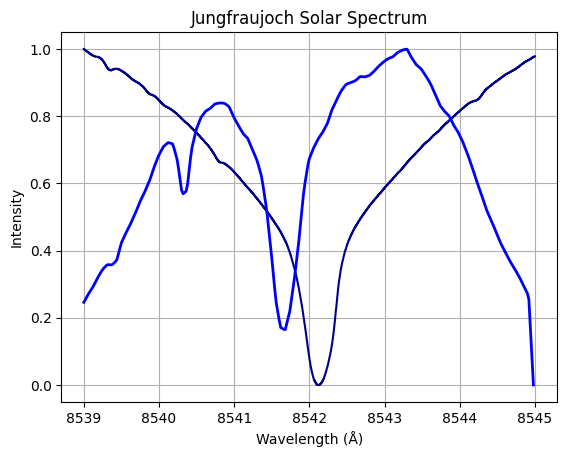

In [62]:
# File path
file = '/content/drive/MyDrive/IBIS_SWG/input/atlas/jun.fits'

wave, spectrum = read_jung_fits(file, w1=8539, w2=8544)
# Find the index of the minimum value.
min_index_atlas = np.argmin(spectrum)
print(min_index_atlas)
sp_norm=(spectrum-np.min(spectrum))/((np.max(spectrum))-np.min(spectrum))

# Print the index of the minimum value.
print(min_index)
# Plot the spectrum

plt.plot(wave, sp_norm, color="darkblue")
plt.plot(wavelengths+8542, Im_p, label="Image_spectralscan", color='b', linewidth=2)

plt.title("Jungfraujoch Solar Spectrum")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity")
plt.grid(True)
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/jungfraujoch_spectrum.png') # Save the plot
plt.show()


In [63]:
wave[-1]

np.float32(8544.998)